# Run the LSST pipeline on VISTA Y and Ks in SXDS with the gen2 Butler.

We will need to ingest all the stacks on a given tile area. Then make the coadds to form the tile. Then detect and measure sources on that tile.

This is done with the 'gen2' butler. While the pipeline tasks are independent of the Butler they are executed using different commands with gen2 or gen3 because the Butler manages the input and output of data to and from the tasks. We will go on to repeat the process with the gen3 Butler.

In [18]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table

import os
import yaml
import glob
import numpy as np

import matplotlib.pyplot as plt

from lsst.geom import degrees
import lsst.daf.persistence as dafPersist

The first stage is to ingest the images. The full commands are 

```Shell
export vista_raw=/path/to/vista/data/folder
mkdir data
echo 'lsst.obs.vista.VistaMapper'>data/_mapper
ingestImages.py data $vista_raw*_st.fit --mode=link --config clobber=True
mkdir -p data/ref_cats
ln -s /path/to/panstarrs/PanSTARRS/ps1_pv3_3pi_20170110_GmagLT19 data/ref_cats/ps1_pv3_3pi_20170110

```
Then we run through the photometry pipeline


```Shell
processCcd.py data --rerun processCcdOutputs --id --clobber-config
#Then we make the skymap discrete makes small section around images with zero indexing
#makeDiscreteSkyMap.py data --id --rerun processCcdOutputs:coadd --config skyMap.projection="TAN"
makeSkyMap.py data --rerun processCcdOutputs:coadd #config in obs_vista
#Then we warp the images to the skymap
makeCoaddTempExp.py data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract=8524 patch=3,6 --config doApplyExternalPhotoCalib=False doApplyExternalSkyWcs=False doApplySkyCorr=False
makeCoaddTempExp.py data --rerun coadd --selectId filter=VISTA-Ks --id filter=VISTA-Ks tract=8524 patch=3,6 --config doApplyExternalPhotoCalib=False doApplyExternalSkyWcs=False doApplySkyCorr=False
#Then we assemble the coadds on test patch
assembleCoadd.py data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract=8524 patch=3,6
assembleCoadd.py data --rerun coadd --selectId filter=VISTA-Ks --id filter=VISTA-Ks tract=8524 patch=3,6
#Lets just run the one tract for now
#Full patches for the test sxds tiles: 
#tract=8523 patch==0,2^0,3^0,4^0,5^0,6^0,7^0,8
#tract=8524 patch=2,2^2,3^2,4^2,5^2,6^2,7^2,8^3,2^3,3^3,4^3,5^3,6^3,7^3,8^4,2^4,3^4,4^4,5^4,6^4,7^4,8^5,2^5,3^5,4^5,5^5,6^5,7^5,8^6,2^6,3^6,4^6,5^6,6^6,7^6,8^7,2^7,3^7,4^7,5^7,6^7,7^7,8^8,2^8,3^8,4^8,5^8,6^8,7^8,8
#Then detect sources 
detectCoaddSources.py data --rerun coadd:coaddPhot --id filter=VISTA-Y tract=8524 patch=3,6
detectCoaddSources.py data --rerun coadd:coaddPhot --id filter=VISTA-Ks tract=8524 patch=3,6
#Merge any detection catalogues
mergeCoaddDetections.py data --rerun coaddPhot --id filter=VISTA-Y^VISTA-Ks tract=8524 patch=3,6
#deblend without tract patch it hangs running over sky
deblendCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Y tract=8524 patch=3,6
deblendCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Ks tract=8524 patch=3,6
# measure positions (before this stage detections are given interms of pixel footprints
measureCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Y tract=8524 patch=3,6
measureCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Ks tract=8524 patch=3,6

mergeCoaddMeasurements.py data --rerun coaddPhot --id filter=VISTA-Y^VISTA-Ks tract=8524 patch=3,6

forcedPhotCoadd.py data --rerun coaddPhot:coaddForcedPhot --id filter=VISTA-Y tract=8524 patch=3,6
forcedPhotCoadd.py data --rerun coaddForcedPhot --id filter=VISTA-Ks tract=8524 patch=3,6
```

The equivalent of all the above commands using the Python api is (every command line task has an associated python task api but not the reverse).




<pre><code>
from lsst.pipe.tasks.ingest import IngestTask


</code></pre>


## 1. Example area

In [../dmu1/2_Survey_comparisons.ipynb](../dmu1/2_Survey_comparisons.ipynb) we found some test VISTA images in the SXDS field (where we have HSC DUD imaging). 

![](./figs/1_sxds_tracts.png)

I simply took the VISTA tiles closest to radec 35., -5. We will see later these tiles are in tracts 8523 and 8524.

In [49]:
def data_loc(base=None):
    """Return data locations depending on machine used
    
    Returns
    -------
    str
        Full path to data repository
    """
    if base == None:
        cwd = os.getcwd()
        base = cwd.split('lsst-ir-fusion')[0] + 'lsst-ir-fusion/'
    
    
    overide = base + 'dmu0/data_local.yml'
    standard = base + 'dmu0/data_local_template.yml'
    print(overide)
    if os.path.exists(overide):
        data_loc = yaml.load(open(overide, 'rb'))
    else:
        data_loc = yaml.load(open(standard, 'rb'))
        for k, v in data_loc.items():
            #print(k,v)
            data_loc[k] = v.replace('BASE/', base)
    return data_loc
data_loc = data_loc()

/Users/rs548/GitHub/lsst-ir-fusion/dmu0/data_local.yml


/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel_launcher.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [109]:
data_loc

{'vista': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/',
 'video': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/',
 'viking': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIKING/data/',
 'vhs': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VHS/data/',
 'hsc': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_HSC/data/',
 'panstarrs': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/',
 'gaia': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_GAIA/data/'}

In [306]:

vista_test = glob.glob(data_loc['vista'] + "**/*st.fit", recursive=True)

In [307]:
vista_test

['/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00102_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00235_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00207_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00186_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00151_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00116_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00179_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00130_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00165_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/2012

In [39]:

import lsst.daf.persistence
DATA_DIR = "/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data/"
butler = lsst.daf.persistence.Butler(DATA_DIR)

In [42]:
butler

Butler(datasetTypeAliasDict={}, repos=RepoDataContainer(_inputs=[RepoData(id=5086610128,repoArgs=RepositoryArgs(root='/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_test', cfgRoot=None, mapper=<class 'lsst.obs.vista.vistaMapper.VistaMapper'>, mapperArgs=None, tags=set(), mode='rw', policy=None)cfg=RepositoryCfg(root='/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_test', mapper=<class 'lsst.obs.vista.vistaMapper.VistaMapper'>, mapperArgs={}, parents=[], policy=None),cfgOrigin=existing,cfgRoot=/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_test,repo=<lsst.daf.persistence.repository.Repository object at 0x12f322790>,parentRepoDatas=[],isV1Repository=True,role=output,parentRegistry=None)], 
_outputs=[RepoData(id=5086610128,repoArgs=RepositoryArgs(root='/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_test', cfgRoot=None, mapper=<class 'lsst.obs.vista.vistaMapper.VistaMapper'>, mapperArgs=None, tags=set(), mode='rw', policy=None)cfg=RepositoryCfg(root='/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_tes

In [102]:
def cutout_scale(im, num_min = 2.0, num_max = 5.0):
    """
    Takes an image array and returns the vmin and vmax required to scale the image 
    between median + 5 * sigma MAD and median - 2 * sigma MAD
    """

    import numpy as np
    import astropy.stats as apys

    data = im.flatten()   #Return a copy of the array collapsed into one dimension

    try:
        med = np.median(data[np.isnan(data)!=1])
        sigma_MAD = apys.mad_std(data[np.isnan(data)!=1])
    except IndexError:
        med = 0.0
        sigma_MAD = 0.0
    vmax = med + num_max * sigma_MAD
    vmin = med - num_min * sigma_MAD

    return vmin, vmax


In [103]:
def plot_fits(im_hdu):
    wcs = WCS(im_hdu.header)
    #wcs = WCS(data_loc + 'private/VISTA/VIDEO/20180911/v20180911_00266_st.fit')
    vmin, vmax = cutout_scale(im_hdu.data)
    plt.subplot(projection=wcs)
    plt.imshow(im_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    plt.grid(color='white', ls='solid')
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')
    


In [319]:
y_test = vista_test[0]
ks_test = vista_test[24]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


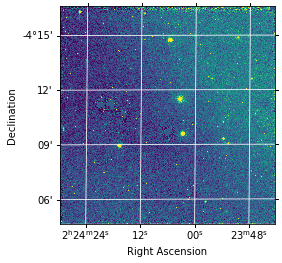

In [320]:
plot_fits(fits.open(y_test)[1]) #The first ccd in the multi extension fits file

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


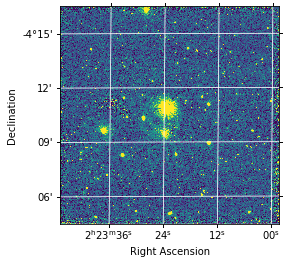

In [321]:
plot_fits(fits.open(ks_test)[1])

In [322]:
#We will need to translate the key header values for the primary unit and each ccd
fits.open(y_test)[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'ESO     '                    / European Southern Observatory         
DATE    = '2012-11-23T01:48:04'         / Date this file was written            
TELESCOP= 'VISTA   '                    / ESO Telescope Name                    
INSTRUME= 'VIRCAM  '                    / Instrument used.                      
OBJECT  = 'No name '           / Original target.                               
RA      =            35.616442          / 02:22:27.9 RA (J2000) pointing (deg)  
DEC     =             -4.723

In [31]:
#The way the lsst stack reads headers is a little different to astropy
from lsst.afw.fits import readMetadata
#md = readMetadata(y_test, 12)
md = readMetadata('/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20171027/v20171027_00133.fit', 1)
md.toDict()

{'XTENSION': 'BINTABLE',
 'BITPIX': 8,
 'NAXIS': 2,
 'NAXIS1': 8,
 'NAXIS2': 2048,
 'PCOUNT': 4830037,
 'GCOUNT': 1,
 'TFIELDS': 1,
 'TTYPE1': 'COMPRESSED_DATA',
 'TFORM1': '1PB(3111)',
 'ZIMAGE': True,
 'ZTILE1': 2048,
 'ZTILE2': 1,
 'ZCMPTYPE': 'RICE_1',
 'ZNAME1': 'BLOCKSIZE',
 'ZVAL1': 32,
 'ZNAME2': 'BYTEPIX',
 'ZVAL2': 4,
 'ZTENSION': 'IMAGE',
 'ZBITPIX': 32,
 'ZNAXIS': 2,
 'ZNAXIS1': 2048,
 'ZNAXIS2': 2048,
 'ZPCOUNT': 0,
 'ZGCOUNT': 1,
 'EXTNAME': 'DET1.CHIP1',
 'ORIGIN': 'ESO',
 'DATE': '2017-10-28T02:04:35.7035',
 'EXPTIME': 60.0,
 'MJD-OBS': 58054.08577429,
 'DATE-OBS': '2017-10-28T02:03:30.8989',
 'CTYPE1': 'RA---ZPN',
 'CTYPE2': 'DEC--ZPN',
 'CRVAL1': 35.4352458307972,
 'CRVAL2': -4.72461916565052,
 'CRPIX1': 5390.2,
 'CRPIX2': 6843.0,
 'ORIGFILE': 'VIRCAM_IMG_OBS301_0083_DET01.fits',
 'CD1_1': -9.47983326258414e-05,
 'CD1_2': -1.15818012656881e-08,
 'CD2_1': 1.15818012656881e-08,
 'CD2_2': -9.47983326258414e-05,
 'ESO DET CHIP ID': 'ESO-Virgo35',
 'ESO DET CHIP LIVE': Tru

In [210]:
md["ESO DET EXP NO"]

KeyError: 'ESO DET EXP NO not found'

In [192]:
md.get('ESO DET IRACE ADC6 FILTER1')

0

## 3. Viewing calibrated images

Checking we can display the result of the VISTA processCcd run which produced calexp exposures and source lists for what it thought was a single exposure (actually a stack we had given it).

These commands send the images to ds9 which needs to be open. 

In [167]:
import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler(inputs='data/rerun/processCcdOutputs')

In [168]:
calexp = butler.get('calexp', dataId={'filter': 'VISTA-Ks', 'visit': 658653, 'ccd': 00})

In [169]:
import lsst.afw.display as afwDisplay

In [170]:
display = afwDisplay.getDisplay()

In [171]:
display.mtv(calexp)

In [172]:
display.setMaskTransparency(60)

In [173]:
display.scale("asinh", "zscale")

In [174]:
display.scale("asinh", -1, 30)

In [175]:
mask = calexp.getMask()
for maskName, maskBit in mask.getMaskPlaneDict().items():
    print('{}: {}'.format(maskName, display.getMaskPlaneColor(maskName)))

BAD: red
CLIPPED: None
CR: magenta
DETECTED: blue
DETECTED_NEGATIVE: cyan
EDGE: yellow
INEXACT_PSF: None
INTRP: green
NO_DATA: orange
OTHERDET: None
REJECTED: None
SAT: green
SENSOR_EDGE: None
SUSPECT: yellow
THISDET: None
UNMASKEDNAN: None


In [176]:
src = butler.get('src', dataId={'filter': 'VISTA-Ks', 'visit': 658653, 'ccd': 00})

In [177]:
print(len(src))

2510


In [178]:
print(src.getSchema())

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_detected", doc="Source was detected as an icSource"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psf_candidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psf_used", doc="Flag set if the source was actually used for PSF determination, as determined by the"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="calib_psf_reserved", doc="set if source was reserved from PSF determination"), Key['Flag'](offset=32, bit=3)),
    (Fiel

In [179]:
print(src.getSchema().getNames())

{'base_SdssShape_xyErr', 'base_CircularApertureFlux_9_0_instFlux', 'base_PsfFlux_instFluxErr', 'base_LocalWcs_CDMatrix_1_1', 'base_SdssShape_instFlux_yy_Cov', 'base_CircularApertureFlux_70_0_instFlux', 'base_Blendedness_abs_parent_instFlux', 'base_PsfFlux_flag', 'base_GaussianFlux_apCorr', 'base_ClassificationExtendedness_value', 'base_Blendedness_abs_child_instFlux', 'base_LocalBackground_flag_noGoodPixels', 'base_LocalPhotoCalibErr', 'base_PixelFlags_flag_edge', 'base_SdssCentroid_yErr', 'base_PixelFlags_flag_cr', 'base_SdssShape_yyErr', 'base_Blendedness_flag_noCentroid', 'base_LocalWcs_CDMatrix_2_2', 'base_CircularApertureFlux_9_0_flag', 'base_SdssShape_psf_yy', 'base_SdssCentroid_flag_badError', 'base_SdssShape_y', 'base_CircularApertureFlux_3_0_instFlux', 'base_SdssCentroid_x', 'base_PixelFlags_flag', 'base_PixelFlags_flag_saturated', 'base_Blendedness_raw_parent_xx', 'base_CircularApertureFlux_50_0_flag_apertureTruncated', 'base_CircularApertureFlux_12_0_flag_apertureTruncated',

In [180]:
print(src.schema.find("calib_psf_used"))

(Key['Flag'](offset=32, bit=2), Field['Flag'](name="calib_psf_used", doc="Flag set if the source was actually used for PSF determination, as determined by the"))


In [181]:
print(src['base_PsfFlux_instFlux'])

[ 275.84392866  188.37984119  274.53402668 ...   90.27500921 1977.76459917
 1719.51642175]


In [182]:
with display.Buffering():
    for s in src:
        display.dot("o", s.getX(), s.getY(), size=10, ctype='orange')
        

In [183]:
display.erase()

In [184]:
with display.Buffering():
    for s in src[src['calib_psf_used']]:
        display.dot("x", s.getX(), s.getY(), size=10, ctype='red')

In [185]:
rejectedPsfSources = src[src['calib_psf_candidate'] &
                         (src['calib_psf_used'] == False)]
with display.Buffering():
    for s in rejectedPsfSources:
        display.dot("+", s.getX(), s.getY(), size=10, ctype='green')

## 4. Warping and Coadding

Remember from the beginning these are run as command line tasks

```Shell
#Make the sky map (we actually use the full sky version now to get the same naming as HSC
makeDiscreteSkyMap.py data --id --rerun processCcdOutputs:coadd --config skyMap.projection="TAN"
#Make the warps (for the first ccd we need a tract with 2*2 patches)
makeCoaddTempExp.py data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract=0 patch=0,0^0,1^1,0^1,1     --config doApplyExternalPhotoCalib=False doApplyExternalSkyWcs=False doApplySkyCorr=False
#Coadd the warps
assembleCoadd.py data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract=0 patch=0,0^0,1^1,0^1,1
```

In order to run these commands we need to know the tracts we wish to warp. If not the command will run over the whole sky and mainly produce empty images. We therefore need to use the lsst stack to get the relevant tracts/patches

In [371]:
#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

#Following taken from dmu1/2_Survey_comparisons.ipynb test choice
coord = SpherePoint(35.429025*degrees,-4.90853*degrees)
config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
#and copied for obs_vista
#https://github.com/lsst-uk/obs_vista/blob/master/config/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 # Overlap between tracts (degrees)
config.pixelScale = 0.168
sm = RingsSkyMap(config)
sm.findTract(coord)

TractInfo(id=8524, ctrCoord=[0.8087076683756161, 0.5811684769959703, -0.09074749834931431])

In [378]:
sm.findTract(coord).findPatch(coord)

PatchInfo(index=(5, 6), innerBBox=(minimum=(20000, 24000), maximum=(23999, 27999)), outerBBox=(minimum=(19900, 23900), maximum=(24099, 28099)))

In [376]:
sm.findTractPatchList(
    [
        SpherePoint(35.429025*degrees,-4.90853*degrees),
        SpherePoint(35.0*degrees,-5.*degrees)
    ]
)

[(TractInfo(id=8524, ctrCoord=[0.8087076683756161, 0.5811684769959703, -0.09074749834931431]),
  (PatchInfo(index=(5, 5), innerBBox=(minimum=(20000, 20000), maximum=(23999, 23999)), outerBBox=(minimum=(19900, 19900), maximum=(24099, 24099))),
   PatchInfo(index=(5, 6), innerBBox=(minimum=(20000, 24000), maximum=(23999, 27999)), outerBBox=(minimum=(19900, 23900), maximum=(24099, 28099))),
   PatchInfo(index=(6, 5), innerBBox=(minimum=(24000, 20000), maximum=(27999, 23999)), outerBBox=(minimum=(23900, 19900), maximum=(28099, 24099))),
   PatchInfo(index=(6, 6), innerBBox=(minimum=(24000, 24000), maximum=(27999, 27999)), outerBBox=(minimum=(23900, 23900), maximum=(28099, 28099))),
   PatchInfo(index=(7, 5), innerBBox=(minimum=(28000, 20000), maximum=(31999, 23999)), outerBBox=(minimum=(27900, 19900), maximum=(32099, 24099))),
   PatchInfo(index=(7, 6), innerBBox=(minimum=(28000, 24000), maximum=(31999, 27999)), outerBBox=(minimum=(27900, 23900), maximum=(32099, 28099))),
   PatchInfo(inde

## 5. Detecting and measuring

```Shell
#Detecting sources I think we don't need to specify tracts and patches defaults to all - however will hang running over full sky tracts
detectCoaddSources.py data --rerun coadd:coaddPhot --id filter=VISTA-Y 
#Next redo this for same area in other band (TODO this will not run now)
#Merge multiband source detection catalogues
#mergeCoaddDetections.py data --rerun coaddPhot --id filter=VISTA-Y^VISTA-z
#Deblending only possible with multiple bands
#deblendCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Y
```

In [ ]:
#Of the 7 or so patches sent to detection and measurement only one passed without error tract: 8523, patch: 0,7

## 6. Working with the Butler
Now we have run through the full gen2 HSC examples on VISTA lets use the gen2 Butler to investigate teh database and products

In [5]:
import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler(inputs='data/rerun/coaddForcedPhot')


In [18]:
tract = 8524 #8524 #8523
patch = '3,5' #'3,5' #0,7

In [19]:
ySources = butler.get('deepCoadd_forced_src', {'filter': 'VISTA-Y', 'tract': tract, 'patch': patch})
ksSources = butler.get('deepCoadd_forced_src', {'filter': 'VISTA-Ks', 'tract': tract, 'patch': patch})

DEBUG:  /Users/rs548/GitHub/lsst-ir-fusion/dmu4/data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Y/8524/3,5/forcedSrc-VISTA-Y-8524-3,5.fits
DEBUG:  /Users/rs548/GitHub/lsst-ir-fusion/dmu4/data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Ks/8524/3,5/forcedSrc-VISTA-Ks-8524-3,5.fits


In [20]:
#Units used in repo
ySources.getSchema().find('base_PsfFlux_instFlux').field.getUnits()


'count'

In [21]:
yCoaddPhotoCalib = butler.get('deepCoadd_forced_src',  {'filter': 'VISTA-Y', 'tract': tract, 'patch': patch})
ksCoaddPhotoCalib = butler.get('deepCoadd_forced_src',  {'filter': 'VISTA-Ks', 'tract': tract, 'patch': patch})

DEBUG:  /Users/rs548/GitHub/lsst-ir-fusion/dmu4/data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Y/8524/3,5/forcedSrc-VISTA-Y-8524-3,5.fits
DEBUG:  /Users/rs548/GitHub/lsst-ir-fusion/dmu4/data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Ks/8524/3,5/forcedSrc-VISTA-Ks-8524-3,5.fits


In [22]:
yCoaddCalexp = butler.get('deepCoadd_calexp',  {'filter': 'VISTA-Y', 'tract': tract, 'patch': patch})
yCoaddPhotoCalib = yCoaddCalexp.getPhotoCalib()

In [23]:
ksCoaddCalexp = butler.get('deepCoadd_calexp',  {'filter': 'VISTA-Ks', 'tract': tract, 'patch': patch})
ksCoaddPhotoCalib = ksCoaddCalexp.getPhotoCalib()

In [24]:
yMags = yCoaddPhotoCalib.instFluxToMagnitude(ySources, 'base_PsfFlux')
ksMags = ksCoaddPhotoCalib.instFluxToMagnitude(ksSources, 'base_PsfFlux')

In [25]:
yFlux = yCoaddPhotoCalib.instFluxToNanojansky(ySources, 'base_PsfFlux')
ksFlux = ksCoaddPhotoCalib.instFluxToNanojansky(ksSources, 'base_PsfFlux')

In [26]:
sn5 = (yFlux[:,0]/yFlux[:,1] > 5) & (ksFlux[:,0]/ksFlux[:,1] > 5)
np.sum(sn5)

ValueError: operands could not be broadcast together with shapes (36237,) (33333,) 

In [ ]:
plt.hist(yFlux[:,0]/yFlux[:,1], range=[0,20], bins=100)

In [ ]:
isDeblended = ySources['deblend_nChild'] == 0

In [ ]:
refTable = butler.get('deepCoadd_ref', {'filter': 'VISTA-Y^VISTA-Ks', 'tract': tract, 'patch': patch})

In [ ]:
refTable

In [ ]:
inInnerRegions = refTable['detect_isPatchInner'] & refTable['detect_isTractInner']

In [ ]:
isSkyObject = refTable['merge_peak_sky']

In [ ]:
isPrimary = refTable['detect_isPrimary']

In [26]:
#These are not present because I don't propagate flags because
#it broke the run due to my setting the ids badly
#ySources.schema.find('base_ClassificationExtendedness_value').field.getDoc()

In [29]:
isStellar = refTable['base_ClassificationExtendedness_value'] < 1.

NameError: name 'refTable' is not defined

In [28]:
ySources.getSchema().extract('base_PsfFlux_*')

{'base_PsfFlux_flag_badCentroid': SchemaItem(key=Key['Flag'](offset=64, bit=7), field=Field['Flag'](name="base_TransformedCentroid_flag", doc="whether the reference centroid is marked as bad")),
 'base_PsfFlux_instFlux': SchemaItem(key=Key<D>(offset=432, nElements=1), field=Field['D'](name="base_PsfFlux_instFlux", doc="instFlux derived from linear least-squares fit of PSF model", units="count")),
 'base_PsfFlux_instFluxErr': SchemaItem(key=Key<D>(offset=440, nElements=1), field=Field['D'](name="base_PsfFlux_instFluxErr", doc="1-sigma instFlux uncertainty", units="count")),
 'base_PsfFlux_area': SchemaItem(key=Key<F>(offset=448, nElements=1), field=Field['F'](name="base_PsfFlux_area", doc="effective area of PSF", units="pixel")),
 'base_PsfFlux_flag': SchemaItem(key=Key['Flag'](offset=424, bit=1), field=Field['Flag'](name="base_PsfFlux_flag", doc="General Failure Flag")),
 'base_PsfFlux_flag_noGoodPixels': SchemaItem(key=Key['Flag'](offset=424, bit=2), field=Field['Flag'](name="base_Psf

In [29]:
isGoodFlux = ~ySources['base_PsfFlux_flag']


In [122]:
selected = isPrimary & isGoodFlux # & isStellar why is stellarity failing?

In [123]:
np.sum(selected)

28763

In [124]:
#selected &= yFlux[:,0]/yFlux[:,1] > 5.
#selected &= ksFlux[:,0]/ksFlux[:,1] > 5.

In [125]:
np.sum(selected)

28763

In [126]:
yMags

array([[24.89791571,  0.52851741],
       [23.59318251,  0.15910664],
       [26.07341639,  1.55999111],
       ...,
       [28.78661999, 19.78689216],
       [27.21299026,  4.51833622],
       [24.30747395,  0.31080077]])

In [127]:
yMags[:,0]

array([24.89791571, 23.59318251, 26.07341639, ..., 28.78661999,
       27.21299026, 24.30747395])

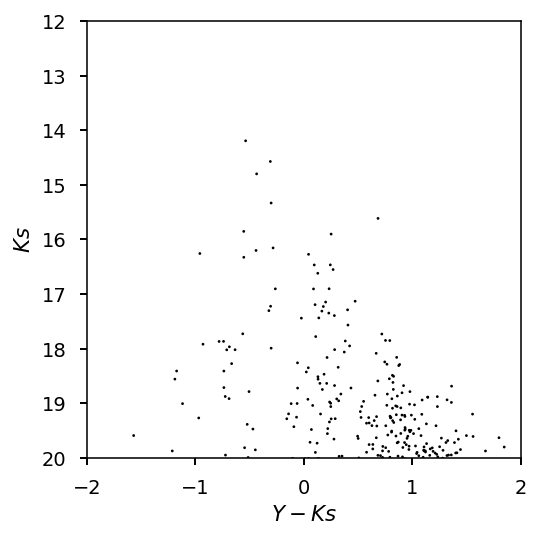

In [159]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(yMags[selected][:,0] - ksMags[selected][:,0],
            ksMags[selected][:,0],
            edgecolors='None', s=2, c='k')
plt.xlim(-2, 2)
plt.ylim(20, 12)
plt.xlabel('$Y-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

Why are there zero values?

/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


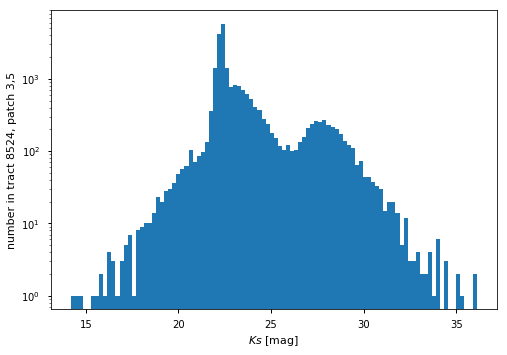

In [129]:
plt.hist(ksMags[selected][:,0], bins=100)
plt.xlabel('$Ks$ [mag]')
plt.ylabel('number in tract {}, patch {}'.format(tract, patch))
plt.yscale('log')

/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


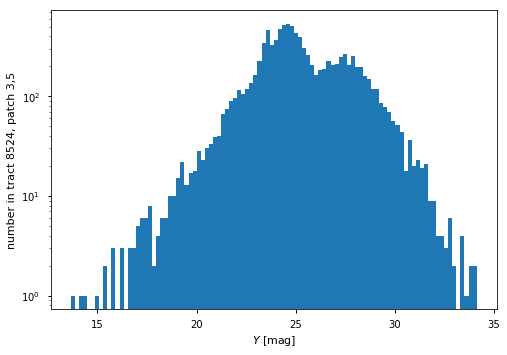

In [121]:
plt.hist(yMags[selected][:,0], bins=100)
plt.xlabel('$Y$ [mag]')
plt.ylabel('number in tract {}, patch {}'.format(tract, patch))
plt.yscale('log')

In [50]:
tile_cat = Table.read(data_loc['video'] + '20171027/v20171027_00133_st_tl_cat.fits')

In [51]:
tile_cat['Kron_flux'].unit

UnrecognizedUnit(ADU)

In [52]:
tile_cat[:10].show_in_notebook()

idx,Sequence_number,Isophotal_flux,X_coordinate,X_coordinate_err,Y_coordinate,Y_coordinate_err,Gaussian_sigma,Ellipticity,Position_angle,Areal_1_profile,Areal_2_profile,Areal_3_profile,Areal_4_profile,Areal_5_profile,Areal_6_profile,Areal_7_profile,Areal_8_profile,Peak_height,Peak_height_err,Aper_flux_1,Aper_flux_1_err,Aper_flux_2,Aper_flux_2_err,Aper_flux_3,Aper_flux_3_err,Aper_flux_4,Aper_flux_4_err,Aper_flux_5,Aper_flux_5_err,Aper_flux_6,Aper_flux_6_err,Aper_flux_7,Aper_flux_7_err,Aper_flux_8,Aper_flux_8_err,Aper_flux_9,Aper_flux_9_err,Aper_flux_10,Aper_flux_10_err,Aper_flux_11,Aper_flux_11_err,Aper_flux_12,Aper_flux_12_err,Aper_flux_13,Aper_flux_13_err,Petr_radius,Kron_radius,Half_radius,Petr_flux,Petr_flux_err,Kron_flux,Kron_flux_err,Half_flux,Half_flux_err,Error_bit_flag,Sky_level,Sky_rms,Av_conf,RA,DEC,Classification,Statistic,MJDoff,Blank64,Blank65,Blank66,Blank67,Blank68,Blank69,Blank70,Blank71,Blank72,Blank73,Blank74,Blank75,Blank76,Blank77,Blank78,Blank79,Blank80
,Number,ADU,Pixels,Pixels,Pixels,Pixels,Pixels,Number,Degrees,Pixels,Pixels,Pixels,Pixels,Pixels,Pixels,Pixels,Pixels,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,Pixels,Pixels,Pixels,ADU,ADU,ADU,ADU,ADU,ADU,Number,ADU,ADU,Number,RADIANS,RADIANS,Flag,N-sigma,Minutes,Blank64,Blank65,Blank66,Blank67,Blank68,Blank69,Blank70,Blank71,Blank72,Blank73,Blank74,Blank75,Blank76,Blank77,Blank78,Blank79,Blank80
0,1.0,400.91217,5327.299,0.08294232,6.9590273,0.076772645,2.181055,0.515074,165.11868,21.0,20.0,13.0,2.0,0.0,0.0,0.0,0.0,32.82459,3.9107492,141.18573,9.535999,240.10841,13.550988,376.81955,19.008017,504.92276,26.107868,683.9447,35.91063,987.26404,50.086475,1581.564,69.99951,2079.0876,87.22096,2534.0574,104.2249,3004.8206,121.22977,3452.0815,138.20679,3947.5693,171.91925,4030.917,205.50002,6.463604,6.463604,2.75868,1724.9237,75.408295,1724.9237,75.408295,341.676,17.65174,5.833021,947.2918,0.014892578,10.7948885,0.62173504,-0.071107306,1.0,6.876411,137.52301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,66.53723,5311.356,0.116902605,9.439828,0.11722132,0.80385315,0.02748096,82.8013,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,21.759184,3.6334596,85.3694,8.965641,122.09432,12.673124,133.35863,17.684334,179.01456,24.82239,294.01938,34.806545,506.35046,49.114403,901.22797,69.022,1225.8889,86.23631,1430.1448,103.15921,1552.1329,120.024216,1803.704,137.00745,2301.0295,170.95702,2789.14,204.89267,2.8209481,2.8209481,3.367335,262.90717,32.710457,262.90717,32.710457,146.8823,19.793825,0.0,947.2926,0.0014648438,16.275906,0.6217615,-0.07111136,-1.0,-0.19967145,137.52301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,2566.1753,5354.5547,0.02550832,6.982853,0.021167547,3.3742547,0.5017164,164.03537,75.0,71.0,51.0,27.0,10.0,2.0,0.0,0.0,151.78291,6.1466327,698.2897,14.008807,1124.3665,18.87063,1568.7545,24.475672,2002.2548,31.342516,2417.2383,40.45408,2815.2327,53.619022,3233.4998,72.31636,3547.4373,88.888504,3937.6174,105.56297,4219.572,122.22768,4554.482,139.00214,5060.5464,172.56543,5858.809,206.38759,8.065146,4.113278,2.3936327,3691.8643,95.15626,2774.561,52.134907,1283.0876,20.970192,1.226326,947.27856,0.014892578,10.996066,0.62168986,-0.07110744,1.0,8.181016,137.52301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,9840.912,4750.2417,0.012322318,8.040152,0.011784591,2.4144502,0.16332304,179.86984,91.0,89.0,65.0,41.0,26.0,20.0,11.0,8.0,819.04193,12.802942,4417.4077,29.988064,6398.7466,37.21353,7966.073,43.302628,8971.198,48.80596,9649.047,55.534885,10146.228,65.91023,10443.963,81.662476,10648.024,96.54598,10696.652,111.781586,10782.002,127.48248,10780.21,143.40968,10742.654,175.82553,10925.245,208.8258,3.9411364,2.6910129,1.581232,10047.212,63.208138,9447.717,53.060062,4920.456,32.61911,0.033794846,947.28644,0.00064086914,10.674081,0.62269235,-0.07110706,-1.0,-1.4282379,137.52301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [53]:
np.sum(tile_cat['Statistic']>5)/81

232.45679012345678

In [54]:
(170000000 / 1270)

133858.26771653543

In [55]:
(1.5*1.5 * (170000000 / 1270))/(9*9)

3718.285214348206

In [56]:
coadd = 'data/rerun/coadd/deepCoadd/VISTA-Ks/8524/3,5'


In [181]:
fits.open('/Volumes/Raph500/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20120924/v20120924_00525.fit')[3].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   32 / # of bits per pix value                        
NAXIS   =                    2 / # of axes in data array                        
NAXIS1  =                 2048 / # of pixels in axis1                           
NAXIS2  =                 2048 / # of pixels in axis2                           
PCOUNT  =                    0 / number of random group parameters              
GCOUNT  =                    1 / number of random groups                        
EXTNAME = 'DET1.CHIP3'         / Extension name                                 
ORIGIN  = 'ESO     ' / European Southern Observatory                            
DATE    = '2012-09-25T06:46:40.1374' / Date the file was written                
EXPTIME =           60.0000000 / Integration time                               
MJD-OBS =       56195.28153138 / Obs start 2012-09-25T06:45:24.311              
DATE-OBS= '2012-09-25T06:45:

In [58]:
fits.open(coadd + '.fits')[1].header

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                  -32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4200 / length of original image axis                  
NAXIS2  =                 4200 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
WCSAXES =                    2 / Number of WCS axes                             
CRPIX1  =                6100. / Reference pixel on axis 1                      
CRPIX2  =               -1900. / Reference pixel on axis 2                      
CRVAL1  =      35.702479338843 / Value at ref. pixel on axis 1                  
CRVAL2  =    -5.20661157024794 / Value at ref. pixel on axis 2                  
CTYPE1  = 'RA---TAN'        

In [59]:
fits.open(coadd + '.fits')[2].header

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4200 / length of original image axis                  
NAXIS2  =                 4200 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
WCSAXES =                    2 / Number of WCS axes                             
CRPIX1  =                6100. / Reference pixel on axis 1                      
CRPIX2  =               -1900. / Reference pixel on axis 2                      
CRVAL1  =      35.702479338843 / Value at ref. pixel on axis 1                  
CRVAL2  =    -5.20661157024794 / Value at ref. pixel on axis 2                  
CTYPE1  = 'RA---TAN'        

In [107]:
fits.open('../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20171027/v20171027_00133_st.fit')[3].header

 [astropy.io.fits.verify]


XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 2135 / length of original image axis                  
NAXIS2  =                 2138 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
EXTNAME = 'DET1.CHIP3'         / Extension name                                 
ORIGIN  = 'ESO     ' / European Southern Observatory                            
DATE    = '2017-10-28T02:04:36.1246' / Date the file was written                
EXPTIME =                  30. / Corrected to ndit = 1                          
MJD-OBS =       58054.08577433 / Obs start 2017-10-28T02:03:30.902              
DATE-OBS= '2017-10-28T02:03:

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


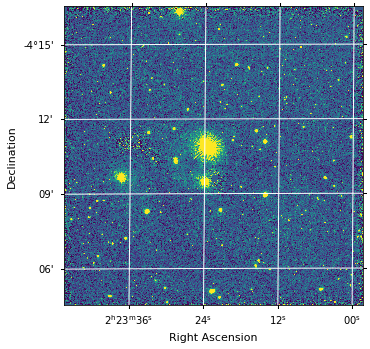

In [112]:
plot_fits(fits.open('../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20171027/v20171027_00133_st.fit')[1])

In [62]:
plot_fits(fits.open(coadd + '.fits')[2])

NameError: name 'plot_fits' is not defined

In [63]:
#This looks like mask flags
np.unique(np.array(fits.open(coadd + '.fits')[2].data).flatten())

array([    0,    32,   512,   544, 49412], dtype=int32)

(array([1.7004312e+07, 0.0000000e+00, 0.0000000e+00, 1.6580000e+03,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.1047900e+05,
        0.0000000e+00, 0.0000000e+00, 4.2290900e+05, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

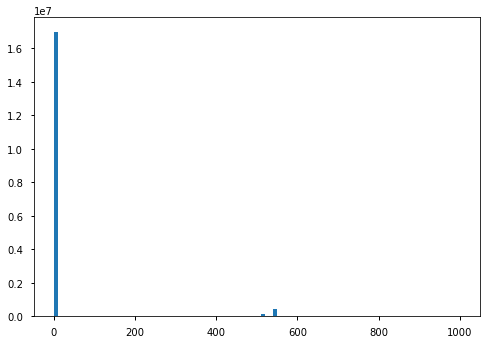

In [64]:
plt.hist(np.array(fits.open(coadd + '.fits')[2].data).flatten(), bins=100, range=[0,1000])

In [65]:
plot_fits(fits.open(coadd + '.fits')[3])

NameError: name 'plot_fits' is not defined

Text(0, 0.5, 'n pixels ')

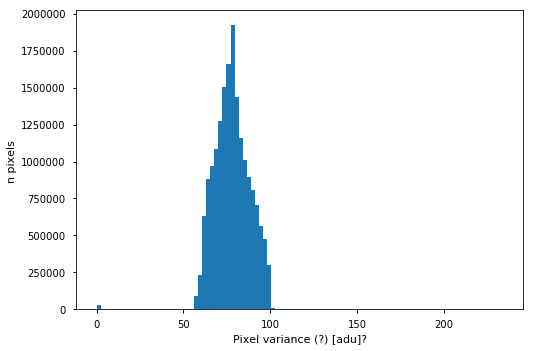

In [66]:
plt.hist(np.array(fits.open(coadd + '.fits')[3].data).flatten(), bins=100)#, range=[0,0.002])
plt.xlabel('Pixel variance (?) [adu]?')
plt.ylabel('n pixels ')

In [67]:
c2 = coadd + '/warp-VISTA-Ks-8524-3,5.fits'


In [68]:
plot_fits(fits.open(c2)[1])

NameError: name 'plot_fits' is not defined

In [69]:
plot_fits(fits.open(c2)[2])

NameError: name 'plot_fits' is not defined

In [70]:
plot_fits(fits.open(c2)[3])

NameError: name 'plot_fits' is not defined

In [71]:
fits.open(c2)[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HIERARCH EXPINFO_V =         1                                                  
AR_HDU  =                    5 / HDU (1-indexed) containing the archive used to 
HIERARCH COADD_INPUTS_ID =   1 / archive ID for generic component 'COADD_INPUTS'
HIERARCH ARCHIVE_ID_COADD_INPUTS = 1 / archive ID for generic component 'COADD_I
HIERARCH AP_CORR_MAP_ID =  376 / archive ID for generic component 'AP_CORR_MAP' 
HIERARCH ARCHIVE_ID_AP_CORR_MAP = 376 / archive ID for generic component 'AP_COR
HIERARCH PHOTOCALIB_ID =    

In [72]:
cat = Table()
cat['f_vista_ks'] = ksFlux[:,0]
cat['ferr_vista_ks'] = ksFlux[:,1]
cat['f_vista_y'] = yFlux[:,0]
cat['ferr_vista_y'] = yFlux[:,1]
cat['m_vista_ks'] = ksMags[:,0]
cat['merr_vista_ks'] = ksMags[:,1]
cat['m_vista_y'] = yMags[:,0]
cat['merr_vista_y'] = yMags[:,1]
cat['ra'] = ySources['coord_ra']
cat['dec'] = ySources['coord_dec']

In [73]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')

    return merged_catalogue

In [74]:
merge = merge_catalogues(cat, tile_cat, 'RA', 'DEC', radius=0.4*u.arcsec)

In [75]:
has_both = (merge['f_vista_ks']>0.) & (merge['Kron_flux'] >0.)
merge[has_both]

f_vista_ks,ferr_vista_ks,f_vista_y,ferr_vista_y,m_vista_ks,merr_vista_ks,m_vista_y,merr_vista_y,ra,dec,flag_merged,Sequence_number,Isophotal_flux,X_coordinate,X_coordinate_err,Y_coordinate,Y_coordinate_err,Gaussian_sigma,Ellipticity,Position_angle,Areal_1_profile,Areal_2_profile,Areal_3_profile,Areal_4_profile,Areal_5_profile,Areal_6_profile,Areal_7_profile,Areal_8_profile,Peak_height,Peak_height_err,Aper_flux_1,Aper_flux_1_err,Aper_flux_2,Aper_flux_2_err,Aper_flux_3,Aper_flux_3_err,Aper_flux_4,Aper_flux_4_err,Aper_flux_5,Aper_flux_5_err,Aper_flux_6,Aper_flux_6_err,Aper_flux_7,Aper_flux_7_err,Aper_flux_8,Aper_flux_8_err,Aper_flux_9,Aper_flux_9_err,Aper_flux_10,Aper_flux_10_err,Aper_flux_11,Aper_flux_11_err,Aper_flux_12,Aper_flux_12_err,Aper_flux_13,Aper_flux_13_err,Petr_radius,Kron_radius,Half_radius,Petr_flux,Petr_flux_err,Kron_flux,Kron_flux_err,Half_flux,Half_flux_err,Error_bit_flag,Sky_level,Sky_rms,Av_conf,Classification,Statistic,MJDoff,Blank64,Blank65,Blank66,Blank67,Blank68,Blank69,Blank70,Blank71,Blank72,Blank73,Blank74,Blank75,Blank76,Blank77,Blank78,Blank79,Blank80
,,,,,,,,rad,rad,,Number,ADU,Pixels,Pixels,Pixels,Pixels,Pixels,Number,Degrees,Pixels,Pixels,Pixels,Pixels,Pixels,Pixels,Pixels,Pixels,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,Pixels,Pixels,Pixels,ADU,ADU,ADU,ADU,ADU,ADU,Number,ADU,ADU,Number,Flag,N-sigma,Minutes,Blank64,Blank65,Blank66,Blank67,Blank68,Blank69,Blank70,Blank71,Blank72,Blank73,Blank74,Blank75,Blank76,Blank77,Blank78,Blank79,Blank80
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
9506.605736478996,509.371483393282,2589.3277744666084,205.20539974042546,21.454936292579184,0.0581746079012501,22.867032425446297,0.08604508633749164,0.6276676702680904,-0.08599550927522316,False,40059.0,47.1427,1774.0367,0.31969878,9006.303,0.31820026,1.0922867,0.11566424,0.88858795,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.6418157,3.224665,42.995018,8.451822,67.072174,12.17377,88.39031,17.304058,101.90172,24.33462,112.52627,34.208862,118.42757,48.135918,160.44122,67.96379,260.96445,85.11012,307.04193,102.06481,250.50963,118.93494,102.782036,135.76044,147.07407,169.69258,177.85309,203.61444,3.7317634,3.7317634,1.779839,112.90482,42.462006,112.90482,42.462006,56.33361,10.607453,0.0,947.1911,0.0049591064,102.35795,1.0,1.7262152,142.31343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5097.354155490756,510.9203648321278,1832.9541167371929,206.01018319025545,22.131637978304028,0.10882601461955241,23.242121015850397,0.12202853982873861,0.6275180019535042,-0.08658525265515357,False,41665.0,30.796814,1865.1517,0.38716888,9362.171,0.3876821,1.0198349,0.20724297,50.267597,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.26594,3.1831925,33.49353,8.342521,58.134747,12.099192,88.402306,17.301186,105.027435,24.344353,109.26471,34.195454,69.702835,48.029736,76.79243,67.83425,20.64867,84.82732,63.8443,101.82629,88.82421,118.79895,49.98802,135.72159,182.93858,169.71376,1193.1698,204.11253,3.4549415,2.5529473,1.9864228,103.22956,39.3286,109.85714,29.24443,54.707077,11.707311,0.0,947.20044,0.005508423,102.898964,1.0,3.1949706,142.21762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7062.580926396702,513.061853296299,5376.7318578367895,206.5845977589742,21.777591406980402,0.0788734083487947,22.0737

Text(0, 0.5, 'VISTA pipeline tile Ks flux [ADU]')

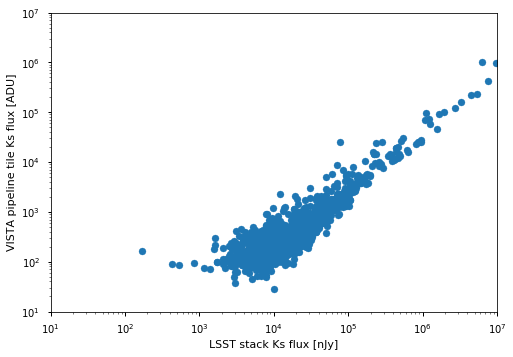

In [94]:
plt.scatter(merge['f_vista_ks'], merge['Kron_flux'])
#plt.plot([0,10**6], [0,10**6], c='r')
plt.xscale('log')
plt.xlabel('LSST stack Ks flux [nJy]')
plt.yscale('log')
plt.xlim([1.E1,1.E7])
plt.ylim([1.E1,1.E7])
plt.ylabel('VISTA pipeline tile Ks flux [ADU]')

Text(0, 0.5, '(f_vista-f_lsst)/f_lsst [meaningless units]')

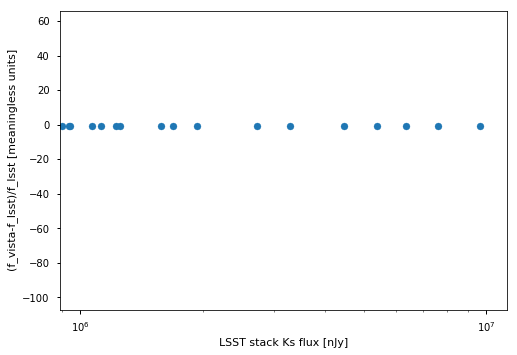

In [77]:
plt.scatter(merge['f_vista_ks'], (merge['Kron_flux'] - merge['f_vista_ks'] )/merge['f_vista_ks'])
plt.xscale('log')
plt.xlabel('LSST stack Ks flux [nJy]')
#plt.yscale('log')
plt.ylabel('(f_vista-f_lsst)/f_lsst [meaningless units]')

From SLack discussion with Carlos:

mag = header['MAZPT'] - 2.5 * log10(data['Aper_flux_N']/header['EXPTIME']) - header['APCORN']

In [78]:
tile_fits = fits.open(data_loc['video'] + '20171027/v20171027_00133_st_tl_cat.fits')

In [79]:
tile_fits[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  320 / width of table in bytes                        
NAXIS2  =                66908 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   80 / number of fields in each row                   
TTYPE1  = 'Sequence_number'    / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'Number  '           / physical unit of field                         
TTYPE2  = 'Isophotal_flux'     / label for field   2                            
TFORM2  = '1E      '        

In [166]:
magzpt = tile_fits[1].header['MAGZPT']
exptime = tile_fits[1].header['EXPTIME']
apcor1 = tile_fits[1].header['APCOR3']

masked_array(data=[--, --, --, ..., False, False, True],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=True)

In [167]:
tile_mags = magzpt - 2.5 * np.log10(merge[has_both]['Aper_flux_3']/exptime) - apcor1

In [176]:
c = merge[has_both ]['m_vista_ks']
plt.scatter(tile_mags[np.isclose(merge['Classification'] , -1)], c[np.isclose(merge['Classification'] , -1)])
plt.xlabel('VISTA pipe Ks AB mags [mag]')
plt.plot([12,26],[12,26], c='r')
plt.xlim([12,24])
plt.ylim([12,24])
plt.ylabel('LSST stack Ks AB mags [mag]')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1076 but corresponding boolean dimension is 102057

Text(0, 0.5, 'LSST stack Ks AB mags [mag] - tile mag')

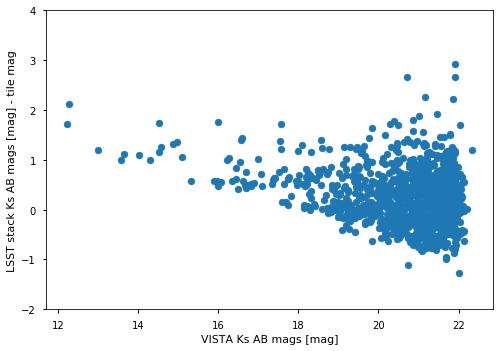

In [169]:
plt.scatter(tile_mags , merge[has_both]['m_vista_ks'] - tile_mags )
plt.xlabel('VISTA Ks AB mags [mag]')
#plt.plot([12,26],[12,26], c='r')
#plt.xlim([12,24])
plt.ylim([-2,4])
plt.ylabel('LSST stack Ks AB mags [mag] - tile mag')

Text(0.5, 0, 'LSST stack mag - VISTA pipe mag [mag]')

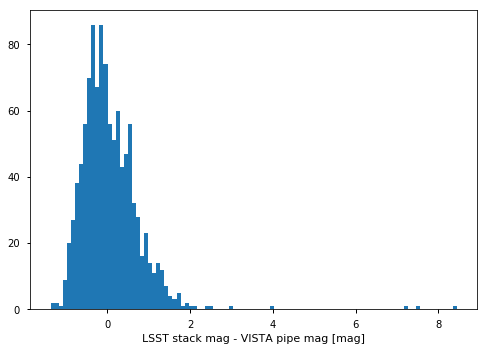

In [90]:
plt.hist(merge[has_both]['m_vista_ks']-tile_mags, bins=100)
plt.xlabel('LSST stack mag - VISTA pipe mag [mag]')

In [131]:
sql = """
SELECT 
    ra, 
    dec, 
    f_vista_y, 
    ferr_vista_y, 
    f_vista_j, 
    ferr_vista_j, 
    f_vista_h, 
    ferr_vista_h, 
    f_vista_ks, 
    ferr_vista_ks 
FROM herschelhelp.main 
WHERE 
    ra > 33.5 
    AND ra < 38. 
    AND dec > -6.5 
    AND dec < -3. 
    AND f_vista_ks IS NOT NULL 
    AND m_gpc1_g < 19.
"""

In [132]:
import pyvo as vo
service = vo.dal.TAPService(
    "https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap"
)

In [133]:
import time
job = service.submit_job(sql)
start_time = time.time()
job.run()
job_url = job.url
job.wait(phases='COMPLETED')
print('Job {} running after {} seconds.'.format(job.phase, round(time.time() - start_time)))

Job COMPLETED running after 43 seconds.


In [134]:
result = job.fetch_result()
v_flux = result.table

In [135]:
len(v_flux)

11075

In [136]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if table[col].dtype == float:
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table

In [137]:
v_flux = clean_table(v_flux)

In [147]:
v_flux['ra'].convert_unit_to(u.rad)
v_flux['dec'].convert_unit_to(u.rad)
for c in v_flux.colnames:
    v_flux[c].name = 'help_' + c


In [146]:
v_flux['help_ra'].name = 'ra'
v_flux['help_dec'].name = 'dec'

In [148]:

help_merge = merge_catalogues(cat, v_flux, 'help_ra', 'help_dec', radius=0.4*u.arcsec)

In [149]:
help_merge[:10].show_in_notebook()

idx,f_vista_ks,ferr_vista_ks,f_vista_y,ferr_vista_y,m_vista_ks,merr_vista_ks,m_vista_y,merr_vista_y,ra,dec,flag_merged,help_f_vista_y,help_ferr_vista_y,help_f_vista_j,help_ferr_vista_j,help_f_vista_h,help_ferr_vista_h,help_f_vista_ks,help_ferr_vista_ks
,,,,,,,,,rad,rad,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy
0,4352.803158984243,543.0738368382094,398.8721501934096,194.16399361094346,22.303077429797668,0.13546096732978583,24.89791571418629,0.5285174144687893,0.6280780421703175,-0.08931494200307842,False,--,--,--,--,--,--,--,--
1,-1462.9030429217278,543.6871976168966,1326.560302058966,194.3976345211735,nan,0.4035133274022018,23.593182508274598,0.15910663811617284,0.6279758235524512,-0.08930847070674235,False,--,--,--,--,--,--,--,--
2,4745.624384269307,545.031311916228,135.0931860253115,194.1025533049518,22.20926659781606,0.12469596836104932,26.073416389588466,1.5599911125028554,0.6278351770606485,-0.08931423175853519,False,--,--,--,--,--,--,--,--
3,6446.523570705123,545.178924299914,1892.2197659572848,194.9441083643547,21.876686062668078,0.0918201088837039,23.207571063070404,0.11185692072526948,0.6276617951591755,-0.08925728959492363,False,--,--,--,--,--,--,--,--
4,4737.60837331425,545.6062834860551,-13.356351451944056,194.41086486070125,22.211102105940128,0.1250387218287374,nan,15.803635845991474,0.6277329569896991,-0.08930450034363453,False,--,--,--,--,--,--,--,--
5,5891.480543766385,546.7602516015447,842.0108827684165,194.7658804931723,21.974438880524417,0.10076200643903893,24.086705738306314,0.25114208406400446,0.6276544574828462,-0.08931023353384106,False,--,--,--,--,--,--,--,--
6,-1308.574432889377,548.5708860540769,1422.808745272135,195.25283240559705,nan,0.4551542937836906,23.517133685234196,0.14899618091943972,0.6275620567668471,-0.08931678614525268,False,--,--,--,--,--,--,--,--
7,79186.40380019572,556.223976966135,49068.72356272517,198.51776405715293,19.15337344948081,0.007626467180786304,19.672988098214365,0.004392572459093177,0.6273884080670792,-0.08897752852005918,False,--,--,--,--,--,--,--,--
8,825.1440014185712,559.2139631412999,1539.6890320889654,186.08857960962013,24.10867563297639,0.7358216807550828,23.43141745973505,0.13122332104948425,0.6273617122155455,-0.08931523436831983,False,--,--,--,--,--,--,--,--


In [151]:
help_and_lsst = (help_merge['help_f_vista_ks'] > 0.) & (help_merge['f_vista_ks'] > 0.)

Text(0, 0.5, 'LSST stack Ks AB mags [mag]')

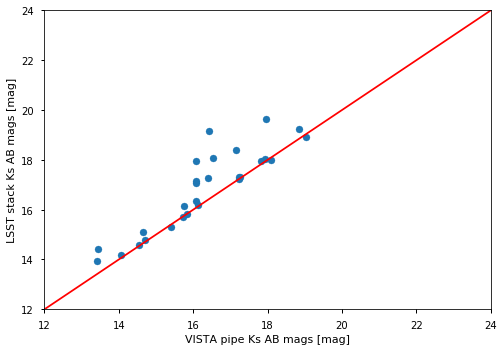

In [156]:
from lsst.afw.image import abMagErrFromFluxErr, abMagFromFlux
plt.scatter(abMagFromFlux(help_merge[help_and_lsst]['help_f_vista_ks']/1.E6), help_merge[help_and_lsst]['m_vista_ks'])
plt.xlabel('VISTA pipe Ks AB mags [mag]')
plt.plot([12,26],[12,26], c='r')
plt.xlim([12,24])
plt.ylim([12,24])
plt.ylabel('LSST stack Ks AB mags [mag]')

Text(0, 0.5, 'LSST stack Ks AB mags [mag]')

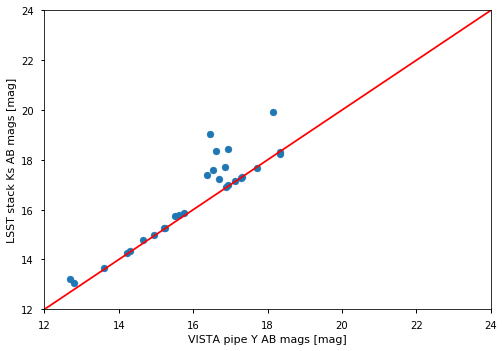

In [157]:
from lsst.afw.image import abMagErrFromFluxErr, abMagFromFlux
plt.scatter(abMagFromFlux(help_merge[help_and_lsst]['help_f_vista_y']/1.E6), help_merge[help_and_lsst]['m_vista_y'])
plt.xlabel('VISTA pipe Y AB mags [mag]')
plt.plot([12,26],[12,26], c='r')
plt.xlim([12,24])
plt.ylim([12,24])
plt.ylabel('LSST stack Ks AB mags [mag]')

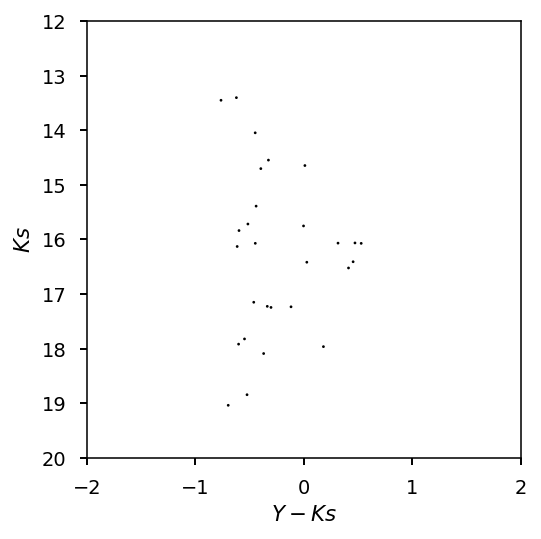

In [160]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(abMagFromFlux(help_merge[help_and_lsst]['help_f_vista_y']/1.E6) - abMagFromFlux(help_merge[help_and_lsst]['help_f_vista_ks']/1.E6),
            abMagFromFlux(help_merge[help_and_lsst]['help_f_vista_ks']/1.E6),
            edgecolors='None', s=2, c='k')
plt.xlim(-2, 2)
plt.ylim(20, 12)
plt.xlabel('$Y-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """


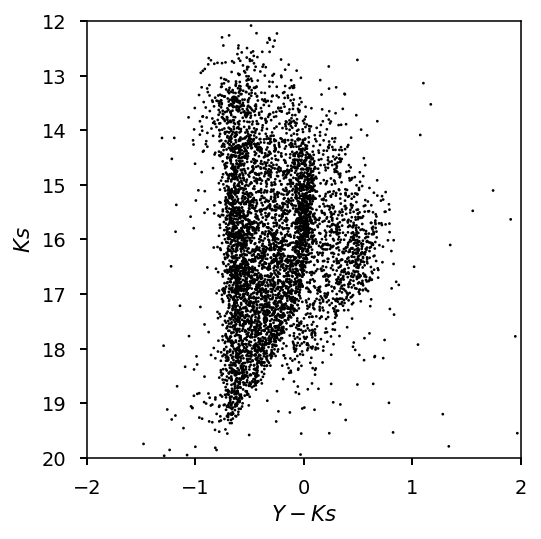

In [161]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(abMagFromFlux(help_merge['help_f_vista_y']/1.E6) - abMagFromFlux(help_merge['help_f_vista_ks']/1.E6),
            abMagFromFlux(help_merge['help_f_vista_ks']/1.E6),
            edgecolors='None', s=2, c='k')
plt.xlim(-2, 2)
plt.ylim(20, 12)
plt.xlabel('$Y-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()